# **CUDA-Pointpillar**

**Author:** [Yi-Jie Wong](https://www.linkedin.com/in/wongyijie/) & [Wingates Voon](https://www.linkedin.com/in/wingates-voon-5858391a0/) & [Yan-Chai Hum](https://www2.utar.edu.my/cv/index.jsp?cv=humyc&reqPageId=aboutMe)<br>
**GitHub:** [Video Analytics](https://github.com/AIProjectsOrg/VARepo)<br>
**Date created:** 2025/06/17<br>
**Last modified:** 2025/07/19<br>
**Description:** Train YOLOv8 for Smoking Detection in CCTV

Pipeline Definition
1.   **Setup Dependencies**
2.   **Setup Dataset**
3.   **Training on Original Dataset**
4.   **Synthetic Dataset**
5.   **Training with Synthetic Dataset**
6.   **Evaluation on All Models**
7.   **Export**

## **Step 1: Setup Dependencies**

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

## **Step 2: Setup Dataset**

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="rvc5pEYx6sd3cZ8EBcDW")
project = rf.workspace("smoking-gqlqh").project("smoking-person-detection-h0a2x-zvlip")
version = project.version(1)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Smoking-Person-Detection-1 in yolov8:: 100%|██████████| 5590/5590 [00:00<00:00, 5679.82it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## **Step 3: Training on Original Dataset**

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="/content/Smoking-Person-Detection-1/data.yaml", epochs=20, imgsz=640, batch=16, val=False)

100%|██████████| 6.25M/6.25M [00:00<00:00, 172MB/s]


Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Smoking-Person-Detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose

100%|██████████| 755k/755k [00:00<00:00, 91.5MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    751897  ultralytics.nn.modules.head.Detect           [3, [64, 128, 256]]           
Model summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 113MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1308.8±1028.9 MB/s, size: 58.5 KB)


train: Scanning /content/Smoking-Person-Detection-1/train/labels... 2284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2284/2284 [00:01<00:00, 1834.41it/s]


train: New cache created: /content/Smoking-Person-Detection-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.1 ms, read: 945.8±728.3 MB/s, size: 95.6 KB)


val: Scanning /content/Smoking-Person-Detection-1/valid/labels... 370 images, 1 backgrounds, 0 corrupt: 100%|██████████| 370/370 [00:00<00:00, 911.31it/s]


val: New cache created: /content/Smoking-Person-Detection-1/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       2.1G      1.268      1.941      1.327         50        640: 100%|██████████| 143/143 [00:48<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.12G      1.333       1.52      1.365         48        640: 100%|██████████| 143/143 [00:45<00:00,  3.16it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.13G      1.374      1.422      1.384         44        640: 100%|██████████| 143/143 [00:43<00:00,  3.27it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.15G      1.346      1.334      1.379         62        640: 100%|██████████| 143/143 [00:43<00:00,  3.31it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.17G      1.323      1.246      1.355         61        640: 100%|██████████| 143/143 [00:43<00:00,  3.29it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.19G      1.285       1.17      1.332         50        640: 100%|██████████| 143/143 [00:43<00:00,  3.31it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.2G      1.249      1.101      1.301         41        640: 100%|██████████| 143/143 [00:44<00:00,  3.21it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.22G      1.215      1.081      1.289         45        640: 100%|██████████| 143/143 [00:43<00:00,  3.33it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.24G      1.202      1.028      1.274         46        640: 100%|██████████| 143/143 [00:43<00:00,  3.28it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.25G       1.17     0.9847      1.254         56        640: 100%|██████████| 143/143 [00:43<00:00,  3.26it/s]


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.27G      1.178     0.9733      1.286         24        640: 100%|██████████| 143/143 [00:49<00:00,  2.87it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.29G      1.132     0.9014      1.254         26        640: 100%|██████████| 143/143 [00:41<00:00,  3.42it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.3G      1.107     0.8701      1.234         27        640: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.32G      1.081     0.8069      1.206         26        640: 100%|██████████| 143/143 [00:42<00:00,  3.39it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.34G      1.045     0.7742      1.196         25        640: 100%|██████████| 143/143 [00:42<00:00,  3.37it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.36G      1.036     0.7557      1.191         34        640: 100%|██████████| 143/143 [00:42<00:00,  3.39it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.37G      1.003     0.7203      1.165         22        640: 100%|██████████| 143/143 [00:42<00:00,  3.40it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.39G     0.9744      0.692      1.145         27        640: 100%|██████████| 143/143 [00:40<00:00,  3.50it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.41G     0.9515     0.6638      1.127         25        640: 100%|██████████| 143/143 [00:41<00:00,  3.46it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.42G     0.9341       0.64      1.123         38        640: 100%|██████████| 143/143 [00:40<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


                   all        370        751      0.773      0.748      0.755      0.493

20 epochs completed in 0.248 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


                   all        370        751      0.774      0.749      0.754      0.493
             cigarette        343        344      0.852      0.791      0.821      0.388
                person        353        381      0.965      0.984      0.985      0.856
                 smoke         18         26      0.505      0.471      0.457      0.234
Speed: 0.4ms preprocess, 2.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/train


In [ ]:
import argparse
from ultralytics import YOLO
from ultralytics.data.dataset import YOLODataset
import ultralytics.data.build as build
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

class YOLOWeightedDataset(YOLODataset):
    def __init__(self, *args, mode="train", **kwargs):
        """
        Initialize the WeightedDataset.

        Args:
            class_weights (list or numpy array): A list or array of weights corresponding to each class.
        """

        super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

        self.train_mode = "train" in self.prefix

        # You can also specify weights manually instead
        self.count_instances()
        class_weights = np.sum(self.counts) / self.counts
        self.agg_func = np.mean

        self.class_weights = np.array(class_weights)
        self.weights = self.calculate_weights()
        self.probabilities = self.calculate_probabilities()

    def count_instances(self):
        """
        Count the number of instances per class

        Returns:
            dict: A dict containing the counts for each class.
        """
        self.counts = [0 for i in range(len(self.data["names"]))]
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)
            for id in cls:
                self.counts[id] += 1

        self.counts = np.array(self.counts)
        self.counts = np.where(self.counts == 0, 1, self.counts)

    def calculate_weights(self):
        """
        Calculate the aggregated weight for each label based on class weights.

        Returns:
            list: A list of aggregated weights corresponding to each label.
        """
        weights = []
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)

            # Give a default weight to background class
            if cls.size == 0:
                weights.append(1)
                continue

            # Take mean of weights
            # You can change this weight aggregation function to aggregate weights differently
            # weight = np.mean(self.class_weights[cls])
            # weight = np.max(self.class_weights[cls])
            weight = self.agg_func(self.class_weights[cls])
            weights.append(weight)
        return weights

    def calculate_probabilities(self):
        """
        Calculate and store the sampling probabilities based on the weights.

        Returns:
            list: A list of sampling probabilities corresponding to each label.
        """
        total_weight = sum(self.weights)
        probabilities = [w / total_weight for w in self.weights]
        return probabilities

    def __getitem__(self, index):
        """
        Return transformed label information based on the sampled index.
        """
        # Don't use for validation
        if not self.train_mode:
            return self.transforms(self.get_image_and_label(index))
        else:
            index = np.random.choice(len(self.labels), p=self.probabilities)
            return self.transforms(self.get_image_and_label(index))

# Monkey patch method
build.YOLODataset = YOLOWeightedDataset

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="/content/Smoking-Person-Detection-1/data.yaml", epochs=20, imgsz=640, batch=16, val=False)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Smoking-Person-Detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

train: Scanning /content/Smoking-Person-Detection-1/train/labels.cache... 2284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2284/2284 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 598.5±356.2 MB/s, size: 95.6 KB)


val: Scanning /content/Smoking-Person-Detection-1/valid/labels.cache... 370 images, 1 backgrounds, 0 corrupt: 100%|██████████| 370/370 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.11G      1.325      2.064      1.407         47        640: 100%|██████████| 143/143 [00:51<00:00,  2.77it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.13G       1.37      1.655      1.423         54        640: 100%|██████████| 143/143 [00:45<00:00,  3.12it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.15G      1.422      1.549      1.456         45        640: 100%|██████████| 143/143 [00:47<00:00,  3.02it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.15G      1.394      1.438      1.425         71        640: 100%|██████████| 143/143 [00:45<00:00,  3.17it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.15G      1.377      1.359       1.42         57        640: 100%|██████████| 143/143 [00:47<00:00,  3.03it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.15G      1.336      1.305      1.378         63        640: 100%|██████████| 143/143 [00:45<00:00,  3.15it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.15G      1.304       1.22      1.364         43        640: 100%|██████████| 143/143 [00:46<00:00,  3.10it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.15G      1.258      1.136      1.338         44        640: 100%|██████████| 143/143 [00:46<00:00,  3.04it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.15G      1.237      1.109      1.327         48        640: 100%|██████████| 143/143 [00:44<00:00,  3.19it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.15G      1.244      1.101      1.329         50        640: 100%|██████████| 143/143 [00:45<00:00,  3.17it/s]


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.15G      1.234      1.065      1.367         30        640: 100%|██████████| 143/143 [00:44<00:00,  3.21it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.15G      1.191     0.9872      1.327         29        640: 100%|██████████| 143/143 [00:48<00:00,  2.95it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.15G      1.146     0.9258      1.293         36        640: 100%|██████████| 143/143 [00:42<00:00,  3.39it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.15G      1.119     0.8659      1.267         30        640: 100%|██████████| 143/143 [00:44<00:00,  3.20it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.15G      1.075     0.8243      1.245         28        640: 100%|██████████| 143/143 [00:43<00:00,  3.29it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.15G       1.06     0.7865      1.226         27        640: 100%|██████████| 143/143 [00:43<00:00,  3.32it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.15G      1.023     0.7698      1.202         32        640: 100%|██████████| 143/143 [00:43<00:00,  3.25it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.15G      1.003     0.7387      1.201         44        640: 100%|██████████| 143/143 [00:42<00:00,  3.35it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.15G     0.9681     0.6957      1.171         23        640: 100%|██████████| 143/143 [00:43<00:00,  3.28it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.15G     0.9442     0.6498      1.157         24        640: 100%|██████████| 143/143 [00:43<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


                   all        370        751      0.832      0.755      0.775      0.481

20 epochs completed in 0.259 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


                   all        370        751      0.831      0.755      0.775      0.481
             cigarette        343        344      0.813      0.741      0.801      0.355
                person        353        381      0.967      0.984      0.986      0.841
                 smoke         18         26      0.712      0.538      0.537      0.247
Speed: 0.3ms preprocess, 2.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/train2


## **Step 4: Synthetic Dataset**

In [ ]:
import os
import requests

# Directory to save the .jpg files
directory = "backgrounds"
os.makedirs(directory, exist_ok=True)

# Indices to skip
skip_indices = [2, 9, 10, 13, 15, 16, 19, 24, 32, 33, 36, 38,
                44, 47, 49, 50, 53, 57, 60, 61, 64, 69, 70, 72,
                73, 75, 77, 78, 90, 92, 93, 95, 96, 97]

# Loop through numbers 1 to 100
for i in range(1, 101):
    if i in skip_indices:
        print(f"Skipping {i}.jpg")
        continue

    url = f"http://graphics.cs.cmu.edu/projects/whatMakesParis/testimgs/{i}.jpg"
    file_path = os.path.join(directory, f"{i}.jpg")

    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {i}.jpg")
    except requests.RequestException as e:
        print(f"Failed to download {i}.jpg: {e}")


Downloaded 1.jpg
Skipping 2.jpg
Downloaded 3.jpg
Downloaded 4.jpg
Downloaded 5.jpg
Downloaded 6.jpg
Downloaded 7.jpg
Downloaded 8.jpg
Skipping 9.jpg
Skipping 10.jpg
Downloaded 11.jpg
Downloaded 12.jpg
Skipping 13.jpg
Downloaded 14.jpg
Skipping 15.jpg
Skipping 16.jpg
Downloaded 17.jpg
Downloaded 18.jpg
Skipping 19.jpg
Downloaded 20.jpg
Downloaded 21.jpg
Downloaded 22.jpg
Downloaded 23.jpg
Skipping 24.jpg
Downloaded 25.jpg
Downloaded 26.jpg
Downloaded 27.jpg
Downloaded 28.jpg
Downloaded 29.jpg
Downloaded 30.jpg
Downloaded 31.jpg
Skipping 32.jpg
Skipping 33.jpg
Downloaded 34.jpg
Downloaded 35.jpg
Skipping 36.jpg
Downloaded 37.jpg
Skipping 38.jpg
Downloaded 39.jpg
Downloaded 40.jpg
Downloaded 41.jpg
Downloaded 42.jpg
Downloaded 43.jpg
Skipping 44.jpg
Downloaded 45.jpg
Downloaded 46.jpg
Skipping 47.jpg
Downloaded 48.jpg
Skipping 49.jpg
Skipping 50.jpg
Downloaded 51.jpg
Downloaded 52.jpg
Skipping 53.jpg
Downloaded 54.jpg
Downloaded 55.jpg
Downloaded 56.jpg
Skipping 57.jpg
Downloaded 58.jpg
D

In [ ]:
import os
len(os.listdir("/content/Smoking-Person-Detection-1/train/labels"))

2284

In [ ]:
import os
import cv2
import numpy as np
import random

def load_yolo_labels(label_path, img_width, img_height):
    bboxes = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            _, x_center, y_center, width, height = map(float, parts)
            x1 = int((x_center - width / 2) * img_width)
            y1 = int((y_center - height / 2) * img_height)
            x2 = int((x_center + width / 2) * img_width)
            y2 = int((y_center + height / 2) * img_height)
            bboxes.append((x1, y1, x2, y2))
    return bboxes

def create_mask(img_shape, bboxes):
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    for (x1, y1, x2, y2) in bboxes:
        cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)
    return mask

def extract_objects(img, bboxes):
    objects = []
    for (x1, y1, x2, y2) in bboxes:
        obj = img[y1:y2, x1:x2]
        objects.append(((x1, y1), obj))
    return objects

def paste_objects_on_background(bg, objects):
    for (x, y), obj in objects:
        h, w = obj.shape[:2]
        if y + h <= bg.shape[0] and x + w <= bg.shape[1]:  # simple bounds check
            bg[y:y+h, x:x+w] = obj
    return bg

def generate_synthetic_dataset(image_dir, label_dir, bg_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    bg_files = [os.path.join(bg_dir, f) for f in os.listdir(bg_dir) if f.endswith(('.jpg', '.png'))]

    for img_file in image_files:
        image_path = os.path.join(image_dir, img_file)
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(label_dir, label_file)
        if not os.path.exists(label_path):
            continue

        img = cv2.imread(image_path)
        img_h, img_w = img.shape[:2]

        bboxes = load_yolo_labels(label_path, img_w, img_h)
        if not bboxes:
            continue

        mask = create_mask(img.shape, bboxes)
        objects = extract_objects(img, bboxes)

        bg_img_path = random.choice(bg_files)
        bg = cv2.imread(bg_img_path)
        bg = cv2.resize(bg, (img_w, img_h))

        new_img = paste_objects_on_background(bg.copy(), objects)

        # Save synthetic image and label in the same directories with prefix
        synthetic_img_name = f"synthetic_{img_file}"
        synthetic_label_name = f"synthetic_{label_file}"

        cv2.imwrite(os.path.join(image_dir, synthetic_img_name), new_img)
        with open(label_path, 'r') as lf, open(os.path.join(label_dir, synthetic_label_name), 'w') as out_lf:
            out_lf.write(lf.read())

        print(f"Generated: {synthetic_img_name} and {synthetic_label_name}")

# Example usage
generate_synthetic_dataset('/content/Smoking-Person-Detection-1/train/images', '/content/Smoking-Person-Detection-1/train/labels', '/content/backgrounds')


Generated: synthetic_a-352-_jpg.rf.1bc3df470ff19aaf002cb21610d1cf57.jpg and synthetic_a-352-_jpg.rf.1bc3df470ff19aaf002cb21610d1cf57.txt
Generated: synthetic_101_jpg.rf.e17a3fffec1da90252fdd551dd3eae4d.jpg and synthetic_101_jpg.rf.e17a3fffec1da90252fdd551dd3eae4d.txt
Generated: synthetic_240876187_1027164644709985_223156136172487091_n_jpg.rf.5e52fcce84d5d324d47b44f9ae205975.jpg and synthetic_240876187_1027164644709985_223156136172487091_n_jpg.rf.5e52fcce84d5d324d47b44f9ae205975.txt
Generated: synthetic_151_jpg.rf.735fa490c4f6500c09c549a3fd71e9a1.jpg and synthetic_151_jpg.rf.735fa490c4f6500c09c549a3fd71e9a1.txt
Generated: synthetic_a-255-_jpg.rf.7f6f60e0cc08e37712ec051d2da49cbf.jpg and synthetic_a-255-_jpg.rf.7f6f60e0cc08e37712ec051d2da49cbf.txt
Generated: synthetic_z2744634299194_fbf6209795ce5e845c739079d3f8303c_jpg.rf.6eb45c821be8078db4afe84f1c0207a6.jpg and synthetic_z2744634299194_fbf6209795ce5e845c739079d3f8303c_jpg.rf.6eb45c821be8078db4afe84f1c0207a6.txt
Generated: synthetic_20211

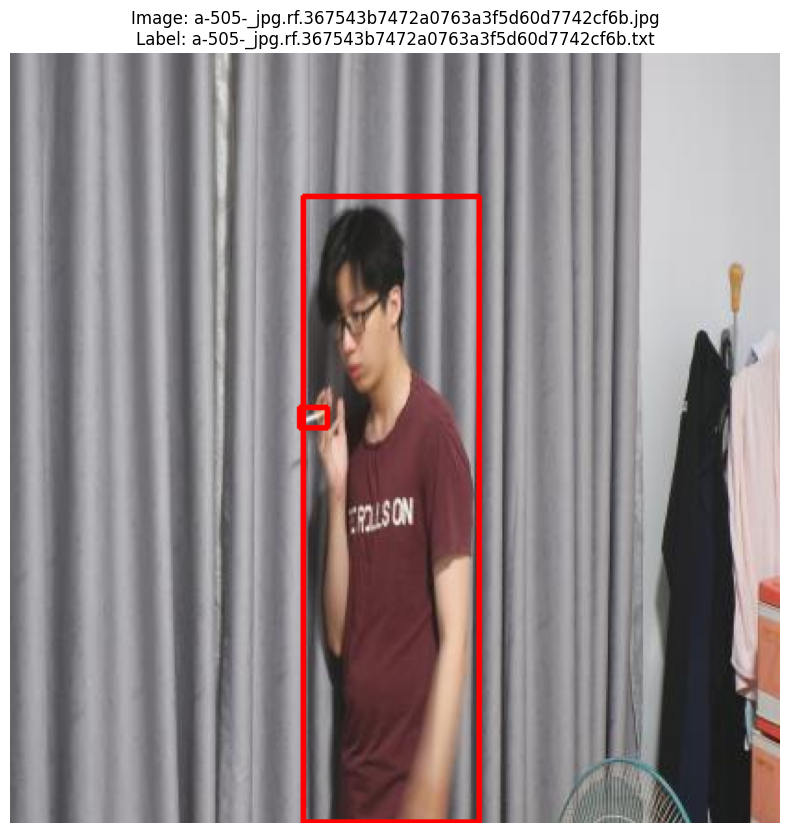

In [ ]:
# prompt: randomly select an image and label pair from "/content/Smoking-Person-Detection-1/train/images" and "/content/Smoking-Person-Detection-1/train/labels". Then plot it out

import random
import matplotlib.pyplot as plt
import cv2
import os

# Define the directories
image_dir = "/content/Smoking-Person-Detection-1/train/images"
label_dir = "/content/Smoking-Person-Detection-1/train/labels"

# Get list of image files
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]

if not image_files:
    print("No image files found in the directory.")
else:
    # Randomly select an image file
    random_image_file = random.choice(image_files)
    image_path = os.path.join(image_dir, random_image_file)

    # Construct the corresponding label file path
    label_file_name = os.path.splitext(random_image_file)[0] + ".txt"
    label_path = os.path.join(label_dir, label_file_name)

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image: {image_path}")
    else:
        # Convert BGR to RGB for displaying with matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get image dimensions
        img_h, img_w, _ = image.shape

        # Read the label file and draw bounding boxes
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        xc, yc, bw, bh = map(float, parts[1:])

                        # Convert YOLO format to pixel coordinates
                        x1 = int((xc - bw / 2) * img_w)
                        y1 = int((yc - bh / 2) * img_h)
                        x2 = int((xc + bw / 2) * img_w)
                        y2 = int((yc + bh / 2) * img_h)

                        # Draw the bounding box (Green color, thickness 2)
                        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

                        # Optionally, put class text on the box (simple example)
                        # cv2.putText(image_rgb, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Plot the image with bounding boxes
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title(f"Image: {random_image_file}\nLabel: {label_file_name}")
        plt.axis('off')  # Hide axes
        plt.show()

## **Step 5: Training with Synthetic Dataset**

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="/content/Smoking-Person-Detection-1/data.yaml", epochs=20, imgsz=640, batch=16, val=False)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Smoking-Person-Detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

train: Scanning /content/Smoking-Person-Detection-1/train/labels... 4568 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4568/4568 [00:02<00:00, 2096.00it/s]

train: New cache created: /content/Smoking-Person-Detection-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 734.5±480.3 MB/s, size: 95.6 KB)


val: Scanning /content/Smoking-Person-Detection-1/valid/labels.cache... 370 images, 1 backgrounds, 0 corrupt: 100%|██████████| 370/370 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.08G     0.9815      1.721      1.208         24        640: 100%|██████████| 286/286 [01:46<00:00,  2.69it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.08G     0.9805      1.265      1.205         34        640: 100%|██████████| 286/286 [01:42<00:00,  2.80it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.09G     0.9998      1.148       1.21         27        640: 100%|██████████| 286/286 [01:39<00:00,  2.88it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.1G     0.9642      1.071      1.194         29        640: 100%|██████████| 286/286 [01:40<00:00,  2.86it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       2.1G     0.8951     0.9679      1.152         37        640: 100%|██████████| 286/286 [01:36<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       2.1G     0.8714     0.9085      1.137         27        640: 100%|██████████| 286/286 [01:34<00:00,  3.02it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.1G      0.851     0.8445      1.125         22        640: 100%|██████████| 286/286 [01:36<00:00,  2.95it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.1G     0.8349     0.8256      1.121         25        640: 100%|██████████| 286/286 [01:37<00:00,  2.93it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       2.1G     0.8203     0.7968      1.111         36        640: 100%|██████████| 286/286 [01:37<00:00,  2.95it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.1G     0.7913     0.7571      1.097         39        640: 100%|██████████| 286/286 [01:35<00:00,  2.99it/s]


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.1G     0.8211     0.7256      1.099         19        640: 100%|██████████| 286/286 [01:34<00:00,  3.02it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       2.1G     0.7746     0.6559       1.07         16        640: 100%|██████████| 286/286 [01:33<00:00,  3.06it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.1G     0.7729     0.6311      1.066         21        640: 100%|██████████| 286/286 [01:34<00:00,  3.02it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       2.1G     0.7716      0.612      1.063         16        640: 100%|██████████| 286/286 [01:32<00:00,  3.10it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.1G     0.7385     0.5683      1.042         20        640: 100%|██████████| 286/286 [01:33<00:00,  3.05it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.1G     0.7142     0.5489      1.031         17        640: 100%|██████████| 286/286 [01:32<00:00,  3.09it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.1G     0.6909     0.5064      1.015         17        640: 100%|██████████| 286/286 [01:32<00:00,  3.10it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.1G     0.6992     0.4934      1.014         20        640: 100%|██████████| 286/286 [01:33<00:00,  3.05it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.11G     0.6714     0.4645     0.9972         16        640: 100%|██████████| 286/286 [01:33<00:00,  3.06it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.12G      0.649     0.4482     0.9852         19        640: 100%|██████████| 286/286 [01:36<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.70it/s]


                   all        370        751      0.824       0.76      0.799      0.496

20 epochs completed in 0.541 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


                   all        370        751      0.824       0.76        0.8      0.497
             cigarette        343        344      0.884      0.753       0.83      0.393
                person        353        381      0.977      0.983      0.987      0.845
                 smoke         18         26      0.611      0.544      0.583      0.253
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/train3


In [ ]:
import argparse
from ultralytics import YOLO
from ultralytics.data.dataset import YOLODataset
import ultralytics.data.build as build
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

class YOLOWeightedDataset(YOLODataset):
    def __init__(self, *args, mode="train", **kwargs):
        """
        Initialize the WeightedDataset.

        Args:
            class_weights (list or numpy array): A list or array of weights corresponding to each class.
        """

        super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

        self.train_mode = "train" in self.prefix

        # You can also specify weights manually instead
        self.count_instances()
        class_weights = np.sum(self.counts) / self.counts
        self.agg_func = np.mean

        self.class_weights = np.array(class_weights)
        self.weights = self.calculate_weights()
        self.probabilities = self.calculate_probabilities()

    def count_instances(self):
        """
        Count the number of instances per class

        Returns:
            dict: A dict containing the counts for each class.
        """
        self.counts = [0 for i in range(len(self.data["names"]))]
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)
            for id in cls:
                self.counts[id] += 1

        self.counts = np.array(self.counts)
        self.counts = np.where(self.counts == 0, 1, self.counts)

    def calculate_weights(self):
        """
        Calculate the aggregated weight for each label based on class weights.

        Returns:
            list: A list of aggregated weights corresponding to each label.
        """
        weights = []
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)

            # Give a default weight to background class
            if cls.size == 0:
                weights.append(1)
                continue

            # Take mean of weights
            # You can change this weight aggregation function to aggregate weights differently
            # weight = np.mean(self.class_weights[cls])
            # weight = np.max(self.class_weights[cls])
            weight = self.agg_func(self.class_weights[cls])
            weights.append(weight)
        return weights

    def calculate_probabilities(self):
        """
        Calculate and store the sampling probabilities based on the weights.

        Returns:
            list: A list of sampling probabilities corresponding to each label.
        """
        total_weight = sum(self.weights)
        probabilities = [w / total_weight for w in self.weights]
        return probabilities

    def __getitem__(self, index):
        """
        Return transformed label information based on the sampled index.
        """
        # Don't use for validation
        if not self.train_mode:
            return self.transforms(self.get_image_and_label(index))
        else:
            index = np.random.choice(len(self.labels), p=self.probabilities)
            return self.transforms(self.get_image_and_label(index))

# Monkey patch method
build.YOLODataset = YOLOWeightedDataset

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="/content/Smoking-Person-Detection-1/data.yaml", epochs=20, imgsz=640, batch=16, val=False)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Smoking-Person-Detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

train: Scanning /content/Smoking-Person-Detection-1/train/labels.cache... 4568 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4568/4568 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 671.6±554.3 MB/s, size: 95.6 KB)


val: Scanning /content/Smoking-Person-Detection-1/valid/labels.cache... 370 images, 1 backgrounds, 0 corrupt: 100%|██████████| 370/370 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.15G     0.9815      1.721      1.208         24        640: 100%|██████████| 286/286 [01:44<00:00,  2.74it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.15G     0.9805      1.265      1.205         34        640: 100%|██████████| 286/286 [01:38<00:00,  2.90it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.15G     0.9998      1.148       1.21         27        640: 100%|██████████| 286/286 [01:36<00:00,  2.96it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.15G     0.9642      1.071      1.194         29        640: 100%|██████████| 286/286 [01:38<00:00,  2.89it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.15G     0.8951     0.9679      1.152         37        640: 100%|██████████| 286/286 [01:37<00:00,  2.92it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.15G     0.8714     0.9085      1.137         27        640: 100%|██████████| 286/286 [01:38<00:00,  2.89it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.16G      0.851     0.8445      1.125         22        640: 100%|██████████| 286/286 [01:39<00:00,  2.89it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.17G     0.8349     0.8256      1.121         25        640: 100%|██████████| 286/286 [01:36<00:00,  2.97it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.17G     0.8203     0.7968      1.111         36        640: 100%|██████████| 286/286 [01:35<00:00,  2.99it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.17G     0.7913     0.7571      1.097         39        640: 100%|██████████| 286/286 [01:35<00:00,  2.98it/s]


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.17G     0.8211     0.7256      1.099         19        640: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.17G     0.7746     0.6559       1.07         16        640: 100%|██████████| 286/286 [01:31<00:00,  3.11it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.17G     0.7729     0.6311      1.066         21        640: 100%|██████████| 286/286 [01:32<00:00,  3.10it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.17G     0.7716      0.612      1.063         16        640: 100%|██████████| 286/286 [01:31<00:00,  3.12it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.18G     0.7385     0.5683      1.042         20        640: 100%|██████████| 286/286 [01:31<00:00,  3.12it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       2.2G     0.7142     0.5489      1.031         17        640: 100%|██████████| 286/286 [01:32<00:00,  3.10it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.21G     0.6909     0.5064      1.015         17        640: 100%|██████████| 286/286 [01:30<00:00,  3.15it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.21G     0.6992     0.4934      1.014         20        640: 100%|██████████| 286/286 [01:30<00:00,  3.15it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.21G     0.6714     0.4645     0.9972         16        640: 100%|██████████| 286/286 [01:30<00:00,  3.15it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.22G      0.649     0.4482     0.9852         19        640: 100%|██████████| 286/286 [01:31<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


                   all        370        751      0.824       0.76      0.799      0.496

20 epochs completed in 0.534 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


                   all        370        751      0.824       0.76        0.8      0.497
             cigarette        343        344      0.884      0.753       0.83      0.393
                person        353        381      0.977      0.983      0.987      0.845
                 smoke         18         26      0.611      0.544      0.583      0.253
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/detect/train4


## **Step 6: Evaluation on All Models**

In [ ]:
# Load the best weights from the training run
model = YOLO("/content/runs/detect/train/weights/last.pt")

# Validate the model on the validation and test set
results = model.val(data="/content/Smoking-Person-Detection-1/data.yaml", split="val", conf=0.10)
results = model.val(data="/content/Smoking-Person-Detection-1/data.yaml", split="test", conf=0.10)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1299.5±699.5 MB/s, size: 71.7 KB)


val: Scanning /content/Smoking-Person-Detection-1/valid/labels.cache... 370 images, 1 backgrounds, 0 corrupt: 100%|██████████| 370/370 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.64it/s]


                   all        370        751      0.774      0.748      0.772      0.518
             cigarette        343        344      0.855      0.791      0.839      0.422
                person        353        381      0.965      0.984       0.99      0.879
                 smoke         18         26      0.503      0.468      0.487      0.254
Speed: 0.7ms preprocess, 4.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 742.0±302.6 MB/s, size: 108.6 KB)


val: Scanning /content/Smoking-Person-Detection-1/test/labels... 135 images, 0 backgrounds, 0 corrupt: 100%|██████████| 135/135 [00:00<00:00, 2032.51it/s]

val: New cache created: /content/Smoking-Person-Detection-1/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.66it/s]


                   all        135        272      0.908       0.89      0.921      0.656
             cigarette        131        131      0.867      0.786      0.854      0.437
                person        132        141      0.948      0.993      0.988      0.875
Speed: 3.4ms preprocess, 5.0ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/val2


In [ ]:
# Load the best weights from the training run
model = YOLO("/content/runs/detect/train2/weights/last.pt")

# Validate the model on the validation and test set
results = model.val(data="/content/Smoking-Person-Detection-1/data.yaml", split="val", conf=0.10)
results = model.val(data="/content/Smoking-Person-Detection-1/data.yaml", split="test", conf=0.10)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1454.4±765.2 MB/s, size: 71.5 KB)


val: Scanning /content/Smoking-Person-Detection-1/valid/labels.cache... 370 images, 1 backgrounds, 0 corrupt: 100%|██████████| 370/370 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.96it/s]


                   all        370        751      0.832      0.755      0.796      0.521
             cigarette        343        344      0.818      0.744      0.827      0.395
                person        353        381      0.967      0.984      0.989      0.867
                 smoke         18         26      0.711      0.538      0.573        0.3
Speed: 0.5ms preprocess, 3.5ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/val3
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1053.7±322.0 MB/s, size: 80.0 KB)


val: Scanning /content/Smoking-Person-Detection-1/test/labels.cache... 135 images, 0 backgrounds, 0 corrupt: 100%|██████████| 135/135 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


                   all        135        272      0.891      0.886      0.914      0.641
             cigarette        131        131       0.84      0.779      0.839      0.426
                person        132        141      0.942      0.993      0.989      0.857
Speed: 4.1ms preprocess, 5.4ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/val4


In [ ]:
# Load the best weights from the training run
model = YOLO("/content/runs/detect/train3/weights/last.pt")

# Validate the model on the validation and test set
results = model.val(data="/content/Smoking-Person-Detection-1/data.yaml", split="val", conf=0.10)
results = model.val(data="/content/Smoking-Person-Detection-1/data.yaml", split="test", conf=0.10)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1836.1±837.9 MB/s, size: 71.7 KB)


val: Scanning /content/Smoking-Person-Detection-1/valid/labels.cache... 370 images, 1 backgrounds, 0 corrupt: 100%|██████████| 370/370 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.83it/s]


                   all        370        751      0.823      0.762      0.817      0.524
             cigarette        343        344      0.881      0.754       0.85      0.432
                person        353        381      0.977      0.984       0.99      0.866
                 smoke         18         26      0.613      0.548      0.612      0.275
Speed: 0.4ms preprocess, 4.1ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/val5
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1587.6±632.4 MB/s, size: 108.6 KB)


val: Scanning /content/Smoking-Person-Detection-1/test/labels.cache... 135 images, 0 backgrounds, 0 corrupt: 100%|██████████| 135/135 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


                   all        135        272      0.914      0.887       0.93      0.645
             cigarette        131        131       0.91      0.773       0.87      0.444
                person        132        141      0.919          1      0.989      0.845
Speed: 3.1ms preprocess, 5.4ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/val6


In [ ]:
# Load the best weights from the training run
model = YOLO("/content/runs/detect/train4/weights/last.pt")

# Validate the model on the validation and test set
results = model.val(data="/content/Smoking-Person-Detection-1/data.yaml", split="val", conf=0.10)
results = model.val(data="/content/Smoking-Person-Detection-1/data.yaml", split="test", conf=0.10)

Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1474.8±959.4 MB/s, size: 71.5 KB)


val: Scanning /content/Smoking-Person-Detection-1/valid/labels.cache... 370 images, 1 backgrounds, 0 corrupt: 100%|██████████| 370/370 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]


                   all        370        751      0.823      0.762      0.817      0.524
             cigarette        343        344      0.881      0.754       0.85      0.432
                person        353        381      0.977      0.984       0.99      0.866
                 smoke         18         26      0.613      0.548      0.612      0.275
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val7
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 988.5±310.3 MB/s, size: 80.0 KB)


val: Scanning /content/Smoking-Person-Detection-1/test/labels.cache... 135 images, 0 backgrounds, 0 corrupt: 100%|██████████| 135/135 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.10it/s]


                   all        135        272      0.914      0.887       0.93      0.645
             cigarette        131        131       0.91      0.773       0.87      0.444
                person        132        141      0.919          1      0.989      0.845
Speed: 4.3ms preprocess, 5.2ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/val8


## **Step 7: Export**

In [4]:
from ultralytics import YOLO

model = YOLO("/content/last.pt")
path = model.export(format='onnx', opset=12, simplify=True, dynamic=False, batch=1, imgsz=320)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/last.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 7, 2100) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 2.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.59...
ONNX: export success ✅ 6.1s, saved as '/content/last.onnx' (11.6 MB)

Export complete (6.7s)
Results saved to /content
Predict:         yolo predict task=detect model=/content/last.onnx imgsz=320  
Validate:        yolo v